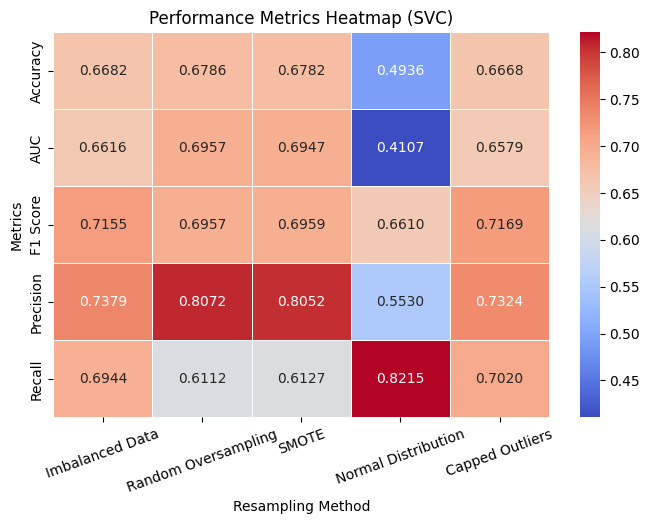

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy import stats

# Load and preprocess your data
df = pd.read_csv('../Data/Encoded_data.csv')
X = df.drop('Reached', axis=1)
y = df['Reached']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of resampling methods
resampling_methods = ["Imbalanced Data", "Random Oversampling", "SMOTE", "Normal Distribution", "Capped Outliers"]
results = {}

for method in resampling_methods:
    if method == "Imbalanced Data":
        X_resampled = X
        y_resampled = y
    elif method == "Random Oversampling":
        ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X, y)
    elif method == "SMOTE":
        smote = SMOTE(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    elif method == "Normal Distribution":
        X_resampled = X_train.copy()
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)  # Convert to DataFrame
        for col in X_resampled.columns:
            # Check if data is positive
            if (X_resampled[col] > 0).all():
                # Apply Box-Cox transformation with a small constant
                X_resampled[col] = stats.boxcox(X_resampled[col] + 0.0001)[0]
            else:
                # Handle non-positive data (you can choose an appropriate action)
                pass
        y_resampled = y_train

    elif method == "Capped Outliers":
        X_resampled = X.copy()
        for col in X_resampled.columns:
            std_dev = X_resampled[col].std()
            X_resampled[col] = np.where(X_resampled[col] > 3 * std_dev, 3 * std_dev, X_resampled[col])
        y_resampled = y

    # Train SVM without hyperparameter tuning
    svm = SVC(C=1, kernel='rbf', random_state=42)
    svm.fit(X_resampled, y_resampled)
    
    # Make predictions on the test set
    y_pred = svm.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Store the results in the dictionary
    results[method] = {
        "Accuracy": accuracy,
        "AUC": auc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Plot a heatmap
plt.figure(figsize=(8,5))
sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title("Performance Metrics Heatmap (SVC)")
plt.xlabel("Resampling Method")
plt.ylabel("Metrics")
plt.xticks(rotation = 20)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import pickle

class BinaryClassifierSVM:
    def __init__(self):
        self.model = None

    def train(self, X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
        self.model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True)
        self.model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, self.model.predict_proba(X_test)[:, 1])

        return accuracy, f1, roc_auc

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.model, file)

# Load your dataset
df = pd.read_csv('../Data/No_outliers.csv')
X = df.drop('Reached', axis=1)
y = df['Reached']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an instance of the BinaryClassifierSVM class
svm_classifier = BinaryClassifierSVM()

# Define the parameter grid for tuning
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

svm_classifier.train(X_train, y_train)
grid_search = GridSearchCV(svm_classifier.model, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
svm_classifier.train(X_train, y_train, kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])

# Evaluate the model
accuracy, f1, roc_auc = svm_classifier.evaluate(X_test, y_test)
print("Best Hyperparameters:", best_params)
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)
print("Test ROC AUC Score:", roc_auc)

# Save the trained SVM model to a pickle file
svm_classifier.save_model('../Pickle_file/svm_model.pkl')
